# Modelo Panel Data

Se realizará un modelo de panel data para hallar las variables determinantes del spread bancario de los bancos en el Perú y así observar el motivo por el cual es elevado.

## Cargar todas las librerías necesarias

In [1]:
library(plm)
library(readxl)
library(reshape2)
library(ggplot2)
library(scales)
library(lmtest)

Loading required package: Formula
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



## Load data
Los datos recolectados para su respectivo análisis provienen de la base de datos de la SBS. Las variables recolectadas van desde los ingresos por créditos, crédito total, depósito total, gastos administrativos,entre otros. El periodo que se ha recolectado es desde el 2009 hasta el 2018 por periodos mensuales. Los bancos de los cuales se ha recolectado su data son:

1. B. Crédito del Perú
2. B. Continental
3. B. Financiero (actualmente Banco Pichincha)
4. B. Interamericano de Finanzas
5. Interbank
6. Mibanco
7. Scotiabank Perú

Siendo en total 11 variables de 120 meses que se han recolectado para los 7 bancos enlistados, dando un total de 9240 datos que se han recolectado de la SBS, cabe destacar que esos datos fueron extraidos por medio de un código en Python. Además, se complementa la data con variables macroeconómicas.

In [2]:
data_path = "../data total.xlsx"
data <- read_excel(data_path, sheet="DATA")
data$Mes <- as.Date(data$Mes)
head(data, n=5)

Mes,code_bank,Banco,dcrisis,ingresos_cred,tot_cart_cred,cost_depo,tot_cart_dep,spread_i,struc_ihh,...,gasto_admi_sbs,num_sucursales,roe,roa,liquidez,Infl,TasaCrec_PBI,Tas_Inter_nom,Tas_Enc,Tas_Inter_efec
2009-01-01,1,B. de Crédito del Perú,1,243674,26328414,62883,34065983,0.007409254,2043.583,...,3.145200,333,0.3935271,2.887088,0.3164,0.10577909,0.046,0.06637327,0.098,0.06843020
2009-02-01,1,B. de Crédito del Perú,1,477289,26866355,116319,34550789,0.014398696,2046.046,...,3.179841,332,0.4079468,3.022523,0.2471,-0.07478670,0.003,0.06409630,0.083,0.06601514
2009-03-01,1,B. de Crédito del Perú,1,718548,26136332,172001,34448235,0.022499277,2014.685,...,3.177028,336,0.3790308,2.817846,0.2602,0.36021910,0.029,0.06080728,0.088,0.06250350
2009-04-01,1,B. de Crédito del Perú,1,949384,25846542,223833,33847372,0.030118558,2012.193,...,3.199297,336,0.3267449,2.451202,0.2514,0.01901134,-0.013,0.05164953,0.089,0.05290309
2009-05-01,1,B. de Crédito del Perú,1,1185229,26186599,269822,32854653,0.037048302,2033.327,...,3.235773,335,0.3157321,2.400915,0.2367,-0.04300599,0.019,0.04010454,0.082,0.04085167


## Convertir a dataframe

In [3]:
panel <- pdata.frame(data, index=c('code_bank', 'Mes'),
                     drop.index=FALSE, row.name=TRUE)

## Función que realiza los test y predicciones
La función realizada acontinuación realiza los distintos modelos de panel data para los distintos modelos que se realizarán, además realiza los respectivos test para observar si existen los problemas de multicolinealidad, autocorrelación, entre otros.

In [4]:
ProcessAnalysis <- function(panel, formula, formula2, num_mod) {

    #####################################################################################################
    #Modelos de panel data.

    femod <- plm(formula2, data=panel, index=c('code_bank', 'Mes'), model="within", effect='individual')
    lmmod <- lm(formula2, data=panel) #Modelo Panel Data con efectos fijos
    ramod <- plm(formula, data=panel, index=c('code_bank', 'Mes'), model='random') #Modelo de Panel Data con efectos aleatorios
    polmod <- plm(formula, data=panel, index=c('code_bank', 'Mes'), model='pooling') #Modelo de Panel Data Pooled OLS

    #####################################################################################################
    #Tests de decición de modelos de panel data.

    haus_test <- phtest(femod, ramod) #Test de Hausman
    print(haus_test)

    BP_test <- plmtest(polmod, type=("bp")) #Test de Breusch-Pagan
    print(BP_test)

    F_test <- pFtest(femod, polmod) #F-test.
    print(F_test)

    #####################################################################################################
    #Resumen de resultados de modelos de panel data.

    if (num_mod == 'Modelo 4') {

        final_model <- ramod
        print(summary(final_model))
        wald_test <- wald_test <- pwaldtest(final_model, test='F') #Test de Wald Heterocedasticidad

    } else {

        final_model <- lmmod
        print(summary(final_model))
        wald_test <- pwaldtest(femod, test='F') #Test de Wald Heterocedasticidad
    }

    #####################################################################################################
    #Obtención de predicciones.

    pred <- predict(final_model)

    panel$pred <- pred

    panel$Mes <- as.Date(panel$Mes)

    melt_panel <- melt(panel, id=c("Mes", "Banco"), 
                        measure=c("spread_i", "pred"))
    #####################################################################################################
    #Figura de las predicciones del modelo.

    fig <- ggplot(melt_panel, aes(x=Mes, y=value, group=Banco, colour=variable)) + 
    geom_point() + facet_grid(Banco ~ ., scale="free_y")

    #####################################################################################################
    #Resultados finales.

    wool_test <- pwartest(formula, data=data) #Test de Wooldridge (Autocorrelación)
    print(wool_test)

    print(wald_test)

    return(list("fig" = fig, "modelo" = final_model))

}

## Gráfico de la variable spread bancario según los bancos
Lo que se resalta del siguiente gráfico es el alto spread que se obtiene por parte del Mibanco.

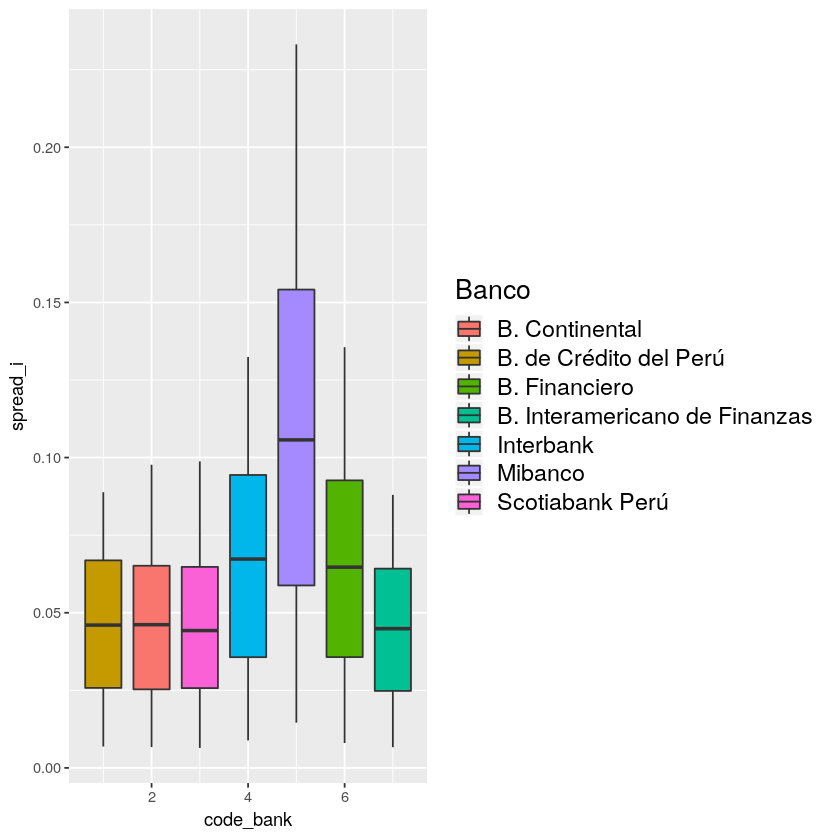

In [5]:
fig2 <- ggplot(data=data, aes(x=code_bank, y=spread_i, group=Banco, fill=Banco))+
    geom_boxplot() + theme(legend.title=element_text(size=16),
                           legend.text=element_text(size=14))
fig2

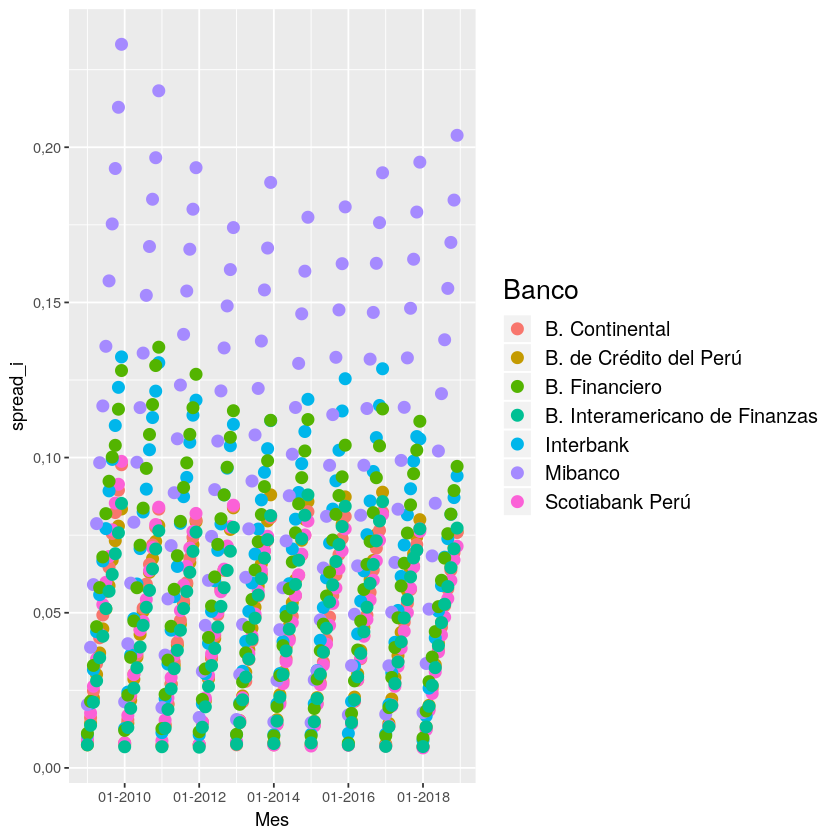

In [6]:
fig3 <- ggplot(data=data, aes(x=Mes, y=spread_i, group=Banco, color=Banco))+
    geom_point(size=3) + theme(legend.title=element_text(size=16),
                           legend.text=element_text(size=12)) +
    scale_x_date(labels=date_format("%m-%Y"))
fig3

## Modelo 1
En este modelo se utilizan las variables de la fórmula mostrada abajo y para el periodo 2009 -2018.

In [7]:
form_mod1 <- spread_i~struc_ihh+ratio_cost_admi+roe+moros_i+
    Infl+Tas_Enc+Tas_Inter_efec+liquidez+solvencia+TasaCrec_PBI

form2_mod1 <- spread_i~struc_ihh+ratio_cost_admi+roe+moros_i+
    Infl+Tas_Enc+Tas_Inter_efec+liquidez+solvencia+TasaCrec_PBI+
    factor(code_bank)-1

res_mod1 <- ProcessAnalysis(panel, form_mod1, form2_mod1, 'Modelo 1')


	Hausman Test

data:  formula2
chisq = 83,93, df = 10, p-value = 8,483e-14
alternative hypothesis: one model is inconsistent


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  formula
chisq = 24,756, df = 1, p-value = 6,508e-07
alternative hypothesis: significant effects


	F test for individual effects

data:  formula2
F = 15,139, df1 = 6, df2 = 823, p-value < 2,2e-16
alternative hypothesis: significant effects


Call:
lm(formula = formula2, data = panel)

Residuals:
     Min       1Q   Median       3Q      Max 
-0,12478 -0,01096  0,00082  0,01378  0,08823 

Coefficients:


Warning message in printCoefmat(coefs, digits = digits, signif.stars = signif.stars, :
“NAs introducidos por coerción”

                     Estimate Std. Error t value Pr(>|t|)    
struc_ihh          -5,109e-05  3,741e-05  -1,366   0,1725    
ratio_cost_admi     1,848e+00  6,371e-02  29,007  < 2e-16 ***
roe                 5,068e-02  2,241e-02   2,262   0,0240 *  
moros_i             1,637e+00  2,078e-01   7,881 1,03e-14 ***
Infl               -3,335e-03  2,959e-03  -1,127   0,2601    
Tas_Enc             1,594e-01  2,490e-02   6,403 2,56e-10 ***
Tas_Inter_efec     -1,224e-01  9,492e-02  -1,290   0,1975    
liquidez            1,808e-02  1,013e-02   1,786   0,0745 .  
solvencia          -8,784e-04  3,473e-04  -2,529   0,0116 *  
TasaCrec_PBI        2,646e-02  3,308e-02   0,800   0,4239    
factor(code_bank)1  6,147e-02  7,798e-02   0,788   0,4307    
factor(code_bank)2  6,982e-02  7,805e-02   0,895   0,3713    
factor(code_bank)3  6,091e-02  7,788e-02   0,782   0,4344    
factor(code_bank)4  6,718e-02  7,816e-02   0,859   0,3903    
factor(code_bank)5  2,045e-02  8,032e-02   0,255   0,7991    
factor(c

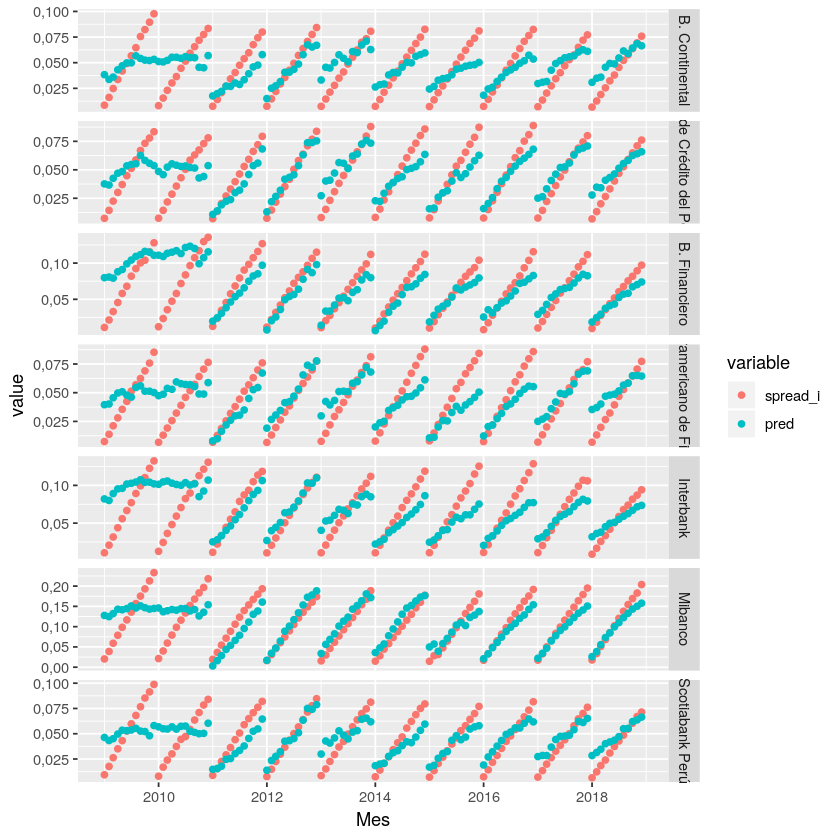

In [8]:
fig_mod1 <- res_mod1$fig
fig_mod1

In [9]:
model1 <- res_mod1$modelo
model1


Call:
lm(formula = formula2, data = panel)

Coefficients:
         struc_ihh     ratio_cost_admi                 roe             moros_i  
        -5,109e-05           1,848e+00           5,068e-02           1,637e+00  
              Infl             Tas_Enc      Tas_Inter_efec            liquidez  
        -3,335e-03           1,594e-01          -1,224e-01           1,808e-02  
         solvencia        TasaCrec_PBI  factor(code_bank)1  factor(code_bank)2  
        -8,784e-04           2,646e-02           6,147e-02           6,982e-02  
factor(code_bank)3  factor(code_bank)4  factor(code_bank)5  factor(code_bank)6  
         6,091e-02           6,718e-02           2,045e-02           4,947e-02  
factor(code_bank)7  
         7,906e-02  


## Modelo 2
Para este modelo se agrega una variable dummy a la fórmula y el periodo de análisis es el mismo.

In [10]:
form_mod2 <- spread_i~dcrisis+struc_ihh+ratio_cost_admi+roe+moros_i+
    Infl+Tas_Enc+Tas_Inter_efec+liquidez+solvencia+TasaCrec_PBI

form2_mod2 <- spread_i~dcrisis+struc_ihh+ratio_cost_admi+roe+moros_i+
    Infl+Tas_Enc+Tas_Inter_efec+liquidez+solvencia+TasaCrec_PBI+
    factor(code_bank)-1

res_mod2 <- ProcessAnalysis(panel, form_mod2, form2_mod2, 'Modelo 2')


	Hausman Test

data:  formula2
chisq = 39,558, df = 11, p-value = 4,257e-05
alternative hypothesis: one model is inconsistent


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  formula
chisq = 9,8672, df = 1, p-value = 0,001683
alternative hypothesis: significant effects


	F test for individual effects

data:  formula2
F = 7,6075, df1 = 6, df2 = 822, p-value = 5,801e-08
alternative hypothesis: significant effects


Call:
lm(formula = formula2, data = panel)

Residuals:
      Min        1Q    Median        3Q       Max 
-0,127253 -0,007217  0,000225  0,007687  0,087664 

Coefficients:


Warning message in printCoefmat(coefs, digits = digits, signif.stars = signif.stars, :
“NAs introducidos por coerción”

                     Estimate Std. Error t value Pr(>|t|)    
dcrisis            -6,220e-02  2,621e-03 -23,736  < 2e-16 ***
struc_ihh          -9,351e-05  2,889e-05  -3,236 0,001259 ** 
ratio_cost_admi     2,362e+00  5,366e-02  44,011  < 2e-16 ***
roe                 4,336e-03  1,738e-02   0,249 0,803079    
moros_i             1,426e-01  1,721e-01   0,829 0,407607    
Infl               -5,402e-03  2,282e-03  -2,367 0,018166 *  
Tas_Enc             1,145e-02  2,018e-02   0,567 0,570700    
Tas_Inter_efec     -6,769e-01  7,680e-02  -8,814  < 2e-16 ***
liquidez            2,608e-02  7,812e-03   3,338 0,000882 ***
solvencia           1,357e-03  2,838e-04   4,783 2,05e-06 ***
TasaCrec_PBI       -5,603e-02  2,573e-02  -2,177 0,029734 *  
factor(code_bank)1  2,042e-01  6,040e-02   3,380 0,000758 ***
factor(code_bank)2  2,108e-01  6,045e-02   3,487 0,000515 ***
factor(code_bank)3  2,091e-01  6,035e-02   3,464 0,000559 ***
factor(code_bank)4  2,073e-01  6,053e-02   3,425 0,000646 ***
factor(c

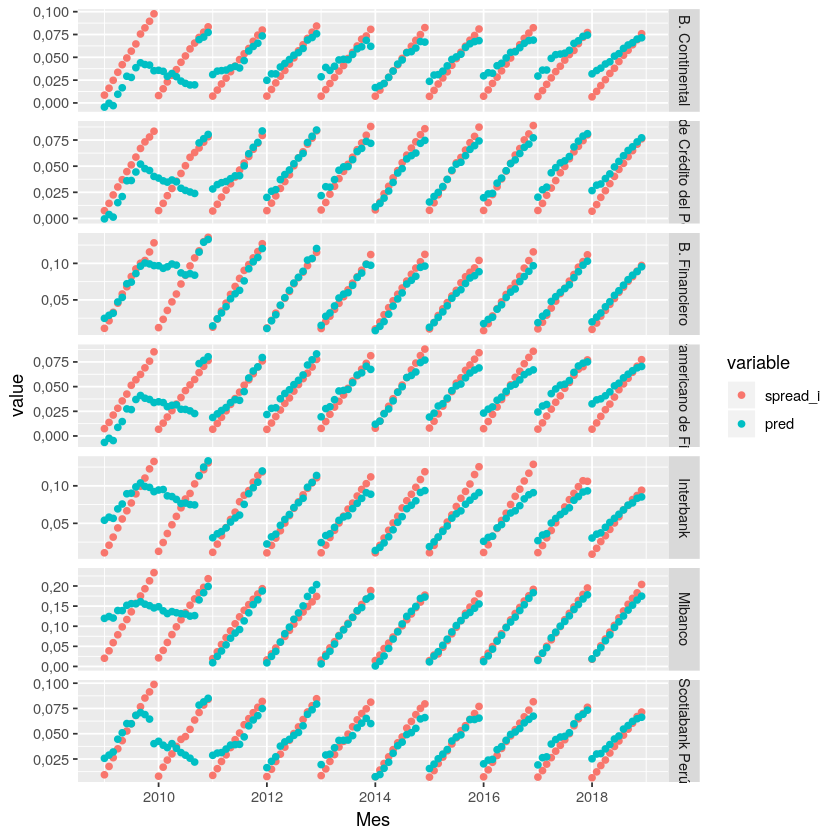

In [11]:
fig_mod2 <- res_mod2$fig
fig_mod2

In [12]:
model2 <- res_mod2$modelo
model2


Call:
lm(formula = formula2, data = panel)

Coefficients:
           dcrisis           struc_ihh     ratio_cost_admi                 roe  
        -6,220e-02          -9,351e-05           2,362e+00           4,336e-03  
           moros_i                Infl             Tas_Enc      Tas_Inter_efec  
         1,426e-01          -5,402e-03           1,145e-02          -6,769e-01  
          liquidez           solvencia        TasaCrec_PBI  factor(code_bank)1  
         2,608e-02           1,357e-03          -5,603e-02           2,042e-01  
factor(code_bank)2  factor(code_bank)3  factor(code_bank)4  factor(code_bank)5  
         2,108e-01           2,091e-01           2,073e-01           1,844e-01  
factor(code_bank)6  factor(code_bank)7  
         1,982e-01           2,063e-01  


## Modelo 3
Dado los resultados anteriores, se decide reducir el periodo de análisis a 2011 - 2018.

In [13]:
#Se usan las fórmulas del Modelo 1.
#Se acota el tiempo de estudio a 2011-2018.

data2 <- data[data$Mes >= "2010/12/31",]
    
#Realiza multindexado de la data acotado
panel2 <- pdata.frame(data2, index=c('code_bank', 'Mes'),
                     drop.index=FALSE, row.name=TRUE)

res_mod3 <- ProcessAnalysis(panel2, form_mod1, form2_mod1, 'Modelo 3')


	Hausman Test

data:  formula2
chisq = 41,522, df = 10, p-value = 9,119e-06
alternative hypothesis: one model is inconsistent


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  formula
chisq = 257,91, df = 1, p-value < 2,2e-16
alternative hypothesis: significant effects


	F test for individual effects

data:  formula2
F = 32,839, df1 = 6, df2 = 655, p-value < 2,2e-16
alternative hypothesis: significant effects


Call:
lm(formula = formula2, data = panel)

Residuals:
      Min        1Q    Median        3Q       Max 
-0,046534 -0,004313 -0,000039  0,004396  0,031391 

Coefficients:


Warning message in printCoefmat(coefs, digits = digits, signif.stars = signif.stars, :
“NAs introducidos por coerción”

                     Estimate Std. Error t value Pr(>|t|)    
struc_ihh          -9,174e-05  1,677e-05  -5,472 6,35e-08 ***
ratio_cost_admi     2,664e+00  2,637e-02 100,999  < 2e-16 ***
roe                 2,558e-02  8,900e-03   2,874 0,004187 ** 
moros_i             9,627e-02  8,766e-02   1,098 0,272540    
Infl               -2,498e-03  1,095e-03  -2,281 0,022840 *  
Tas_Enc            -4,937e-02  1,020e-02  -4,841 1,61e-06 ***
Tas_Inter_efec     -1,211e-02  9,494e-02  -0,128 0,898543    
liquidez            2,511e-03  4,197e-03   0,598 0,549963    
solvencia           1,773e-03  2,390e-04   7,421 3,62e-13 ***
TasaCrec_PBI       -5,848e-02  1,710e-02  -3,420 0,000666 ***
factor(code_bank)1  1,746e-01  3,292e-02   5,304 1,55e-07 ***
factor(code_bank)2  1,772e-01  3,283e-02   5,398 9,44e-08 ***
factor(code_bank)3  1,821e-01  3,300e-02   5,520 4,89e-08 ***
factor(code_bank)4  1,801e-01  3,293e-02   5,469 6,46e-08 ***
factor(code_bank)5  1,559e-01  3,383e-02   4,607 4,92e-06 ***
factor(c

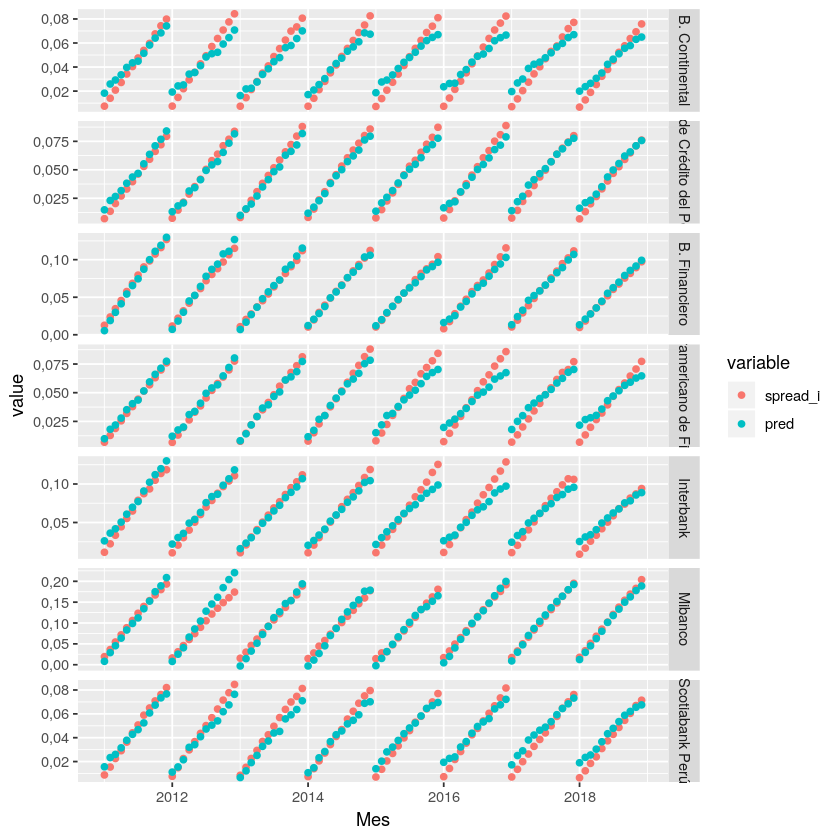

In [14]:
fig_mod3 <- res_mod3$fig
fig_mod3

In [15]:
model3 <- res_mod3$modelo
model3


Call:
lm(formula = formula2, data = panel)

Coefficients:
         struc_ihh     ratio_cost_admi                 roe             moros_i  
        -9,174e-05           2,664e+00           2,558e-02           9,627e-02  
              Infl             Tas_Enc      Tas_Inter_efec            liquidez  
        -2,498e-03          -4,937e-02          -1,211e-02           2,511e-03  
         solvencia        TasaCrec_PBI  factor(code_bank)1  factor(code_bank)2  
         1,773e-03          -5,848e-02           1,746e-01           1,772e-01  
factor(code_bank)3  factor(code_bank)4  factor(code_bank)5  factor(code_bank)6  
         1,821e-01           1,801e-01           1,559e-01           1,715e-01  
factor(code_bank)7  
         1,727e-01  


## Modelo 4
En este último modelo se extrae las variables que no resultaron significativas en el anterior modelo.

In [16]:
form_mod4 <- spread_i~struc_ihh+ratio_cost_admi+roe+
    Infl+Tas_Enc+solvencia+TasaCrec_PBI

form2_mod4 <- spread_i~struc_ihh+ratio_cost_admi+roe+
    Infl+Tas_Enc+solvencia+TasaCrec_PBI+factor(code_bank)-1

res_mod4 <- ProcessAnalysis(panel2, form_mod4, form2_mod4, 'Modelo 4')


	Hausman Test

data:  formula2
chisq = 2,0933, df = 7, p-value = 0,9545
alternative hypothesis: one model is inconsistent


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  formula
chisq = 1296,4, df = 1, p-value < 2,2e-16
alternative hypothesis: significant effects


	F test for individual effects

data:  formula2
F = 55,578, df1 = 6, df2 = 658, p-value < 2,2e-16
alternative hypothesis: significant effects

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = formula, data = panel, model = "random", index = c("code_bank", 
    "Mes"))

Balanced Panel: n = 7, T = 96, N = 672

Effects:


Warning message in printCoefmat(sigma2Table, digits):
“NAs introducidos por coerción”

                    var   std.dev share
idiosyncratic 5,979e-05 7,733e-03 0,837
individual    1,168e-05 3,418e-03 0,163
theta: 0,775

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0,04920881 -0,00425008 -0,00013505  0,00459364  0,03327346 

Coefficients:


Warning message in printCoefmat(coef(x), digits = digits):
“NAs introducidos por coerción”

                   Estimate  Std. Error  z-value  Pr(>|z|)    
(Intercept)      1,9514e-01  2,6564e-02   7,3461 2,041e-13 ***
struc_ihh       -9,9964e-05  1,3796e-05  -7,2457 4,303e-13 ***
ratio_cost_admi  2,6361e+00  2,6046e-02 101,2088 < 2,2e-16 ***
roe              2,3120e-02  5,9413e-03   3,8913 9,969e-05 ***
Infl            -2,8751e-03  1,0983e-03  -2,6177  0,008852 ** 
Tas_Enc         -4,9222e-02  8,8115e-03  -5,5861 2,323e-08 ***
solvencia        1,7193e-03  2,3078e-04   7,4499 9,341e-14 ***
TasaCrec_PBI    -6,4667e-02  1,6394e-02  -3,9446 7,992e-05 ***
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

Total Sum of Squares:    0,71381
Residual Sum of Squares: 0,041105
R-Squared:      0,94241
Adj. R-Squared: 0,94181
Chisq: 10866,6 on 7 DF, p-value: < 2,22e-16


Warning message:
“attributes are not identical across measure variables; they will be dropped”


	Wooldridge's test for serial correlation in FE panels

data:  plm.model
F = 99,021, df1 = 1, df2 = 718, p-value < 2,2e-16
alternative hypothesis: serial correlation


	F test

data:  formula
F = 1552,4, df1 = 7, df2 = 664, p-value < 2,2e-16



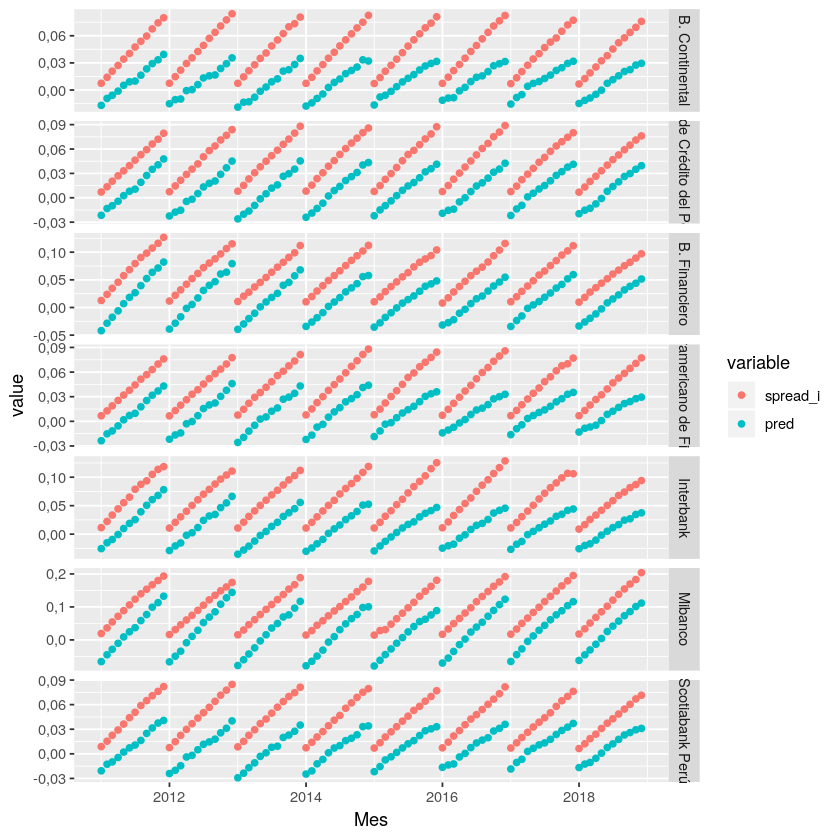

In [17]:
fig_mod4 <- res_mod4$fig
fig_mod4

In [18]:
model4 <- res_mod4$modelo
model4


Model Formula: spread_i ~ struc_ihh + ratio_cost_admi + roe + Infl + Tas_Enc + 
    solvencia + TasaCrec_PBI

Coefficients:
    (Intercept)       struc_ihh ratio_cost_admi             roe            Infl 
     1,9514e-01     -9,9964e-05      2,6361e+00      2,3120e-02     -2,8751e-03 
        Tas_Enc       solvencia    TasaCrec_PBI 
    -4,9222e-02      1,7193e-03     -6,4667e-02 
